In [1]:
import pandas as pd

# Load the dataset (update the path to where your Attrition.csv is located)
df = pd.read_csv('Attrition.csv')

# Drop irrelevant column
df = df.drop('EmployeeNumber', axis=1)

# Check for missing values and basic info
print("Missing values per column:")
print(df.isnull().sum())
print("\nDataFrame Info:")
print(df.info())

# Convert Attrition to binary (0 = No, 1 = Yes)
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})

# Preview the first few rows
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Confirm shape
print("\nShape of DataFrame:", df.shape)

Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLas

In [3]:
# Add new features
df['TenurePerCompany'] = df['TotalWorkingYears'].div(df['NumCompaniesWorked'].replace(0, 1))
df['PromotionLag'] = df['YearsSinceLastPromotion'].div(df['YearsAtCompany'].replace(0, 1))
df['EngagementScore'] = (df['JobSatisfaction'] + df['EnvironmentSatisfaction'] +
                         df['RelationshipSatisfaction'] + df['WorkLifeBalance']) / 16

# Bin features
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 45, 60], labels=['Young', 'Middle', 'Senior'])
df['DistanceGroup'] = pd.cut(df['DistanceFromHome'], bins=[0, 5, 15, 30], labels=['Near', 'Medium', 'Far'])

# One-hot encoding
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or col in ['AgeGroup', 'DistanceGroup']]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Preview
print("Feature engineering completed!")
print("New columns added:", ['TenurePerCompany', 'PromotionLag', 'EngagementScore', 'AgeGroup', 'DistanceGroup'])
print(df_encoded.head())
print("Shape of updated DataFrame:", df_encoded.shape)

Feature engineering completed!
New columns added: ['TenurePerCompany', 'PromotionLag', 'EngagementScore', 'AgeGroup', 'DistanceGroup']
   Age  Attrition  DailyRate  DistanceFromHome  Education  EmployeeCount  \
0   41          1       1102                 1          2              1   
1   49          0        279                 8          1              1   
2   37          1       1373                 2          2              1   
3   33          0       1392                 3          4              1   
4   27          0        591                 2          1              1   

   EnvironmentSatisfaction  HourlyRate  JobInvolvement  JobLevel  ...  \
0                        2          94               3         2  ...   
1                        3          61               2         2  ...   
2                        4          92               2         1  ...   
3                        4          56               3         1  ...   
4                        1          40     

In [5]:
import plotly.express as px

# Treemap: Attrition by Job Role
job_attrition = df.groupby(['JobRole', 'Attrition']).size().reset_index(name='Count')
job_attrition['Attrition'] = job_attrition['Attrition'].map({0: 'No', 1: 'Yes'})
fig1 = px.treemap(job_attrition, path=['JobRole', 'Attrition'], values='Count', 
                  title='Attrition by Job Role', color='Attrition', 
                  color_discrete_map={'No': '#00CC96', 'Yes': '#EF553B'})
fig1.write_html('attrition_jobrole.html')
print("Treemap saved as 'attrition_jobrole.html'")

Treemap saved as 'attrition_jobrole.html'


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap: Correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='Blues', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png', dpi=300)
plt.close()
print("Heatmap saved as 'correlation_heatmap.png'")

Heatmap saved as 'correlation_heatmap.png'


In [11]:
import plotly.express as px

# Scatter: Engagement vs. Income
df['Attrition_str'] = df['Attrition'].map({0: 'No', 1: 'Yes'})
fig2 = px.scatter(df, x='EngagementScore', y='MonthlyIncome', color='Attrition_str', 
                  size='TotalWorkingYears', hover_data=['JobRole'], 
                  title='Engagement vs. Income by Attrition',
                  color_discrete_map={'No': '#00CC96', 'Yes': '#EF553B'})
fig2.write_html('engagement_attrition.html')
print("Scatter saved as 'engagement_attrition.html'")

Scatter saved as 'engagement_attrition.html'


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Print training completion
print("Random Forest model trained successfully!")
print("Training set score:", rf.score(X_train, y_train))
print("Test set score:", rf.score(X_test, y_test))

Random Forest model trained successfully!
Training set score: 1.0
Test set score: 0.8741496598639455


In [15]:
from sklearn.metrics import classification_report
import pandas as pd
import plotly.express as px

# Predictions
y_pred = rf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 10 features
top_10 = feature_importance.head(10)
fig = px.bar(top_10, x='Feature', y='Importance', 
             title='Top 10 Feature Importance', 
             labels={'Importance': 'Importance Score'})
fig.write_html('feature_importance.html')
print("Feature importance plot saved as 'feature_importance.html'")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.67      0.10      0.18        39

    accuracy                           0.87       294
   macro avg       0.77      0.55      0.55       294
weighted avg       0.85      0.87      0.83       294

Feature importance plot saved as 'feature_importance.html'


In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]  # Handle class imbalance
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)
print("Training set score:", best_rf.score(X_train, y_train))
print("Test set score:", best_rf.score(X_test, y_test))

# Re-evaluate with best model
y_pred_best = best_rf.predict(X_test)
print("Updated Classification Report:")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score (CV): 0.3467634481283618
Training set score: 0.9974489795918368
Test set score: 0.8809523809523809
Updated Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94       255
           1       0.75      0.15      0.26        39

    accuracy                           0.88       294
   macro avg       0.82      0.57      0.60       294
weighted avg       0.87      0.88      0.85       294



In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the best model on SMOTE data
best_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)
best_rf.fit(X_train_smote, y_train_smote)

# Evaluate
print("Training set score (SMOTE):", best_rf.score(X_train_smote, y_train_smote))
print("Test set score (SMOTE):", best_rf.score(X_test, y_test))

# Predictions and classification report
y_pred_smote = best_rf.predict(X_test)
print("Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote))

C:\Users\jaswe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\jaswe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jaswe\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jaswe\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jaswe\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable

Training set score (SMOTE): 0.9943762781186094
Test set score (SMOTE): 0.8945578231292517
Classification Report (SMOTE):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       255
           1       0.79      0.28      0.42        39

    accuracy                           0.89       294
   macro avg       0.84      0.64      0.68       294
weighted avg       0.88      0.89      0.87       294



In [21]:
import numpy as np
from sklearn.metrics import classification_report

# Get predicted probabilities
y_prob_smote = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for Class 1

# Set a lower threshold (e.g., 0.3) to increase recall
threshold = 0.3
y_pred_adjusted = (y_prob_smote >= threshold).astype(int)

# Evaluate with adjusted threshold
print(f"Classification Report (SMOTE, Threshold = {threshold}):")
print(classification_report(y_test, y_pred_adjusted))

# Optional: Test multiple thresholds
thresholds = [0.2, 0.3, 0.4]
for thresh in thresholds:
    y_pred_thresh = (y_prob_smote >= thresh).astype(int)
    print(f"\nThreshold = {thresh}:")
    print(classification_report(y_test, y_pred_thresh))

Classification Report (SMOTE, Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       255
           1       0.33      0.62      0.43        39

    accuracy                           0.79       294
   macro avg       0.63      0.71      0.65       294
weighted avg       0.85      0.79      0.81       294


Threshold = 0.2:
              precision    recall  f1-score   support

           0       0.95      0.57      0.71       255
           1       0.22      0.79      0.34        39

    accuracy                           0.60       294
   macro avg       0.58      0.68      0.53       294
weighted avg       0.85      0.60      0.66       294


Threshold = 0.3:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       255
           1       0.33      0.62      0.43        39

    accuracy                           0.79       294
   macro avg       0.63      0.71      0.65 

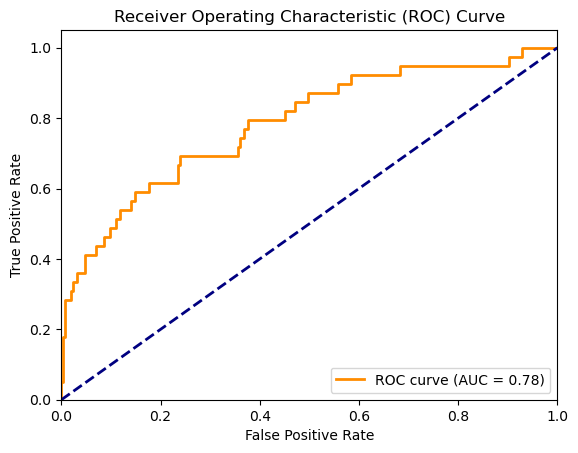

Threshold: 0.497, TPR: 0.282, FPR: 0.020
Threshold: 0.473, TPR: 0.308, FPR: 0.020
Threshold: 0.468, TPR: 0.308, FPR: 0.024
Threshold: 0.468, TPR: 0.333, FPR: 0.024
Threshold: 0.466, TPR: 0.333, FPR: 0.031
Threshold: 0.464, TPR: 0.359, FPR: 0.031
Threshold: 0.457, TPR: 0.359, FPR: 0.047
Threshold: 0.448, TPR: 0.410, FPR: 0.047
Threshold: 0.434, TPR: 0.410, FPR: 0.071
Threshold: 0.429, TPR: 0.436, FPR: 0.071
Threshold: 0.409, TPR: 0.436, FPR: 0.086
Threshold: 0.409, TPR: 0.462, FPR: 0.086
Threshold: 0.375, TPR: 0.462, FPR: 0.098
Threshold: 0.371, TPR: 0.487, FPR: 0.098
Threshold: 0.366, TPR: 0.487, FPR: 0.110
Threshold: 0.361, TPR: 0.513, FPR: 0.110
Threshold: 0.348, TPR: 0.513, FPR: 0.118
Threshold: 0.348, TPR: 0.538, FPR: 0.118
Threshold: 0.324, TPR: 0.538, FPR: 0.141
Threshold: 0.323, TPR: 0.564, FPR: 0.141
Threshold: 0.318, TPR: 0.564, FPR: 0.149
Threshold: 0.318, TPR: 0.590, FPR: 0.149
Threshold: 0.310, TPR: 0.590, FPR: 0.176
Threshold: 0.308, TPR: 0.615, FPR: 0.176
Threshold: 0.283

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_smote)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print some threshold suggestions
for i in range(len(thresholds)):
    if thresholds[i] < 0.5 and thresholds[i] >= 0.2:  # Focus on 0.2–0.5 range
        print(f"Threshold: {thresholds[i]:.3f}, TPR: {tpr[i]:.3f}, FPR: {fpr[i]:.3f}")

In [25]:
import joblib

# Save the model
joblib.dump(best_rf, 'attrition_model.pkl')

# Example prediction function
def predict_attrition(new_data, threshold=0.3):
    # Load the model
    model = joblib.load('attrition_model.pkl')
    # Predict probabilities
    probs = model.predict_proba(new_data)[:, 1]
    # Apply threshold
    predictions = (probs >= threshold).astype(int)
    return predictions

# Example usage (replace `new_data` with your actual new data)
# new_data = X_test.iloc[0:5]  # Example: first 5 rows of test set
# predictions = predict_attrition(new_data)
# print("Predictions for new data:", predictions)

Training set score (XGBoost): 1.0
Test set score (XGBoost): 0.8571428571428571
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       255
           1       0.44      0.28      0.34        39

    accuracy                           0.86       294
   macro avg       0.67      0.61      0.63       294
weighted avg       0.84      0.86      0.84       294



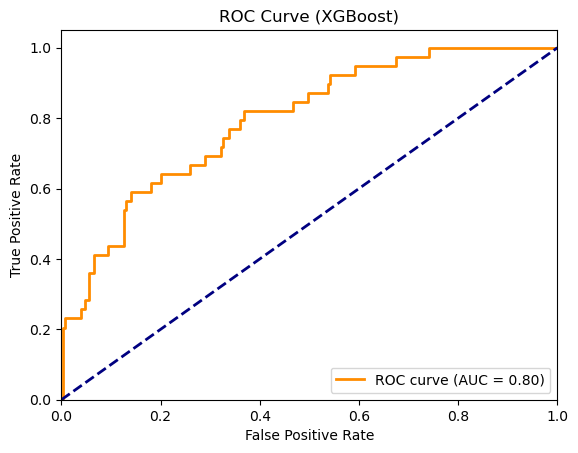

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train XGBoost with SMOTE data
xgb = XGBClassifier(
    scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]),  # Handle imbalance
    max_depth=6,
    n_estimators=200,
    random_state=42
)
xgb.fit(X_train_smote, y_train_smote)

# Evaluate
print("Training set score (XGBoost):", xgb.score(X_train_smote, y_train_smote))
print("Test set score (XGBoost):", xgb.score(X_test, y_test))

# Predictions and classification report
y_pred_xgb = xgb.predict(X_test)
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# ROC curve for XGBoost
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc="lower right")
plt.show()

In [29]:
import joblib
import pandas as pd

# Load the model
model = joblib.load('attrition_model.pkl')

# Prediction function (with threshold = 0.3)
def predict_attrition(new_data, threshold=0.3):
    probs = model.predict_proba(new_data)[:, 1]
    predictions = (probs >= threshold).astype(int)
    return predictions

# Example: Use the first 5 rows of X_test as "new data"
new_data = X_test.iloc[0:5]
predictions = predict_attrition(new_data)
print("Predictions for new data:", predictions)

# Optional: If you have actual new data (e.g., a CSV file), load and predict
# new_data = pd.read_csv('new_employee_data.csv')  # Replace with your file
# Ensure new_data has the same features as X_train (e.g., same columns, preprocessing)
# predictions = predict_attrition(new_data)
# print("Predictions for new data:", predictions)

Predictions for new data: [0 0 1 0 0]


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       255
           1       0.71      0.38      0.50        39

    accuracy                           0.90       294
   macro avg       0.81      0.68      0.72       294
weighted avg       0.89      0.90      0.88       294

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.70       255
           1       0.17      0.56      0.26        39

    accuracy                           0.57       294
   macro avg       0.53      0.57      0.48       294
weighted avg       0.80      0.57      0.64       294



C:\Users\jaswe\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\jaswe\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

C:\Users\jaswe\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will f

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       255
           1       0.38      0.49      0.43        39

    accuracy                           0.83       294
   macro avg       0.65      0.68      0.66       294
weighted avg       0.85      0.83      0.84       294

Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       255
           1       0.30      0.59      0.40        39

    accuracy                           0.77       294
   macro avg       0.61      0.69      0.63       294
weighted avg       0.84      0.77      0.79       294



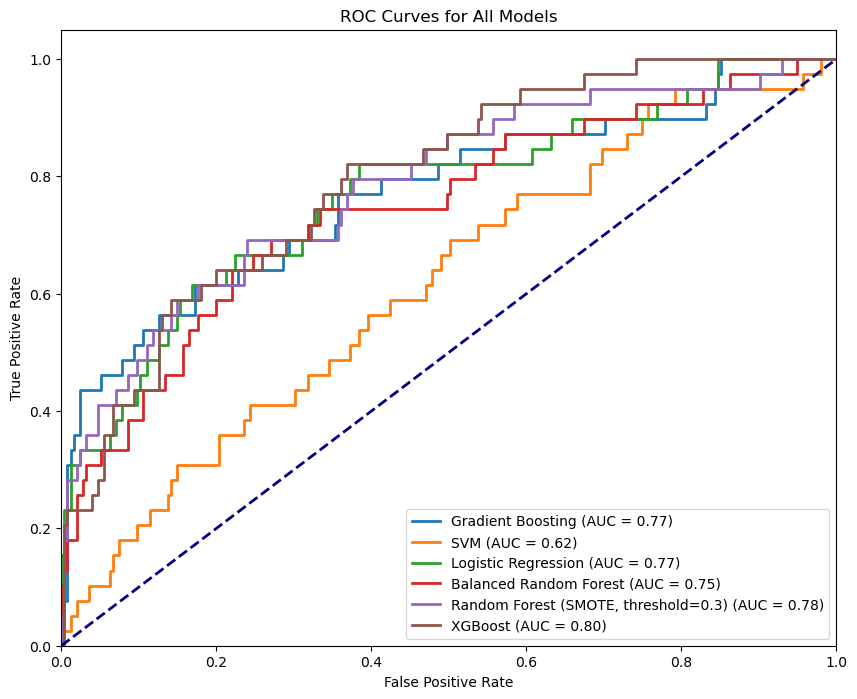

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

# Dictionary to store results
results = {}

# 1. Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=42)
gb.fit(X_train_smote, y_train_smote)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]
results['Gradient Boosting'] = (y_pred_gb, y_prob_gb)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# 2. SVM with class weighting
svm = SVC(probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train_smote, y_train_smote)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]
results['SVM'] = (y_pred_svm, y_prob_svm)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# 3. Logistic Regression with class weighting
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]
results['Logistic Regression'] = (y_pred_lr, y_prob_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# 4. Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
brf.fit(X_train, y_train)  # No SMOTE needed, as it handles imbalance internally
y_pred_brf = brf.predict(X_test)
y_prob_brf = brf.predict_proba(X_test)[:, 1]
results['Balanced Random Forest'] = (y_pred_brf, y_prob_brf)
print("Balanced Random Forest Classification Report:")
print(classification_report(y_test, y_pred_brf))

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, (_, y_prob) in results.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Add Random Forest (SMOTE, threshold = 0.3) for comparison
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_smote)  # From earlier Random Forest
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (SMOTE, threshold=0.3) (AUC = {roc_auc_rf:.2f})')

# Add XGBoost for comparison
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()

Logistic Regression (Scaled) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       255
           1       0.53      0.46      0.49        39

    accuracy                           0.87       294
   macro avg       0.72      0.70      0.71       294
weighted avg       0.87      0.87      0.87       294

Balanced Random Forest (Updated Parameters) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       255
           1       0.36      0.38      0.37        39

    accuracy                           0.83       294
   macro avg       0.63      0.64      0.63       294
weighted avg       0.83      0.83      0.83       294



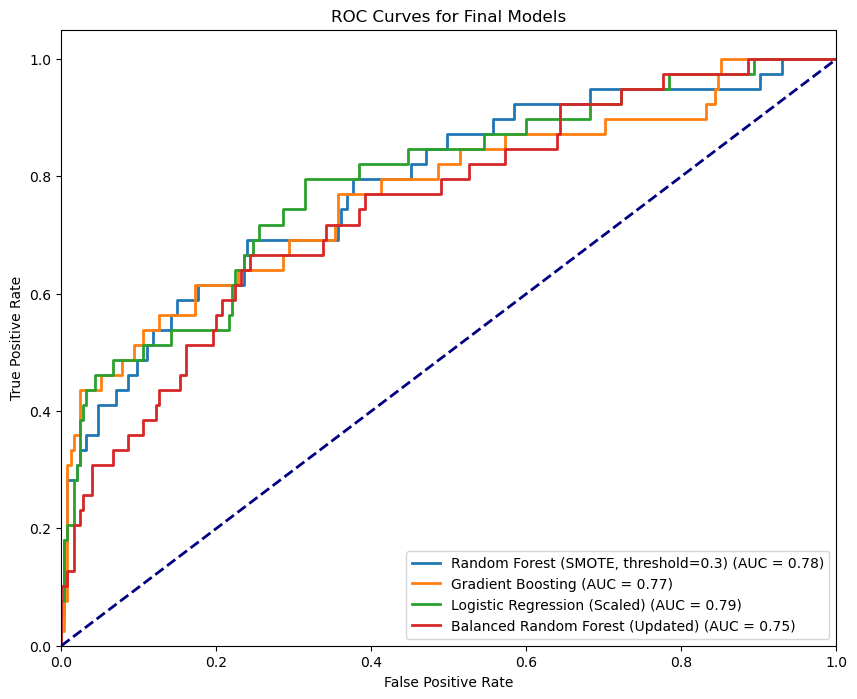

In [33]:
from sklearn.preprocessing import StandardScaler

# Scale the data for Logistic Regression
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Re-run Logistic Regression with scaled data and higher max_iter
lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
lr.fit(X_train_smote_scaled, y_train_smote)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression (Scaled) Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Re-run Balanced Random Forest with explicit parameters
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    sampling_strategy='all',
    replacement=True,
    bootstrap=False
)
brf.fit(X_train, y_train)  # No SMOTE needed
y_pred_brf = brf.predict(X_test)
y_prob_brf = brf.predict_proba(X_test)[:, 1]
print("Balanced Random Forest (Updated Parameters) Classification Report:")
print(classification_report(y_test, y_pred_brf))

# Re-plot ROC curves for final comparison
plt.figure(figsize=(10, 8))

# Random Forest (SMOTE, threshold = 0.3)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_smote)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (SMOTE, threshold=0.3) (AUC = {roc_auc_rf:.2f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')

# Logistic Regression (Scaled)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (Scaled) (AUC = {roc_auc_lr:.2f})')

# Balanced Random Forest (Updated)
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_prob_brf)
roc_auc_brf = auc(fpr_brf, tpr_brf)
plt.plot(fpr_brf, tpr_brf, lw=2, label=f'Balanced Random Forest (Updated) (AUC = {roc_auc_brf:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Final Models')
plt.legend(loc="lower right")
plt.show()